In [14]:
%pylab inline
import keras
import keras.backend as K
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from keras import Input, Model, Sequential
from keras.layers import *
from keras.losses import *
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy', 'multiply', 'add', 'maximum', 'concatenate', 'dot', 'subtract', 'average', 'poisson', 'get', 'minimum']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [15]:
def split_data(dataset, timesteps):
    D = dataset.shape[1]
    if D < timesteps:
        return None
    elif D == timesteps:
        return dataset
    else:
        splitted_data, remaining_data = np.hsplit(dataset, [timesteps])
        remaining_data = split_data(remaining_data, timesteps)
        if remaining_data is not None:
            return np.vstack([splitted_data, remaining_data])
        return splitted_data

In [68]:
normalized_transactions_filepath = "../../datasets/berka_dataset/usable/normalized_transactions_months.npy"

timesteps = 90
transactions = np.load(normalized_transactions_filepath)
transactions = split_data(transactions, timesteps)
# tramsactions = (transactions + 1.0) / 2.0

validation_split = 0.2
N, D = transactions.shape
split_index = int(N*(1-validation_split))

training_transactions = transactions[:split_index]
test_transactions = transactions[split_index:]
print(training_transactions.shape)
print(test_transactions.shape)

(86400, 90)
(21600, 90)


In [36]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], 784))
x_train.shape

timesteps = 784
transactions = x_train / 255
transactions.shape

(60000, 784)

# Autoencoders

In [69]:
lr = 0.0001
epochs = 50
loss = logcosh
latent_dim = 2
lstm_dim = 8
optimizer = 'adam'

indexes = np.random.choice(range(split_index, N), 16, replace=False)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00005, patience=10, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto', epsilon=0.0005, cooldown=0, min_lr=0)

In [70]:
def plot_predictions(autoencoder, indexes, data, reverse=False, add_timesteps=False):
    plt.subplots(4, 4, figsize=(15, 5))
    steps = np.reshape(np.arange(0, 1, 1/timesteps), (1, timesteps))
    print(steps.shape)
    
    for i, index in enumerate(indexes):
        plt.subplot(4, 4, i+1)
        plt.plot(data[index])
        if reverse:
            if add_timesteps:
                plt.plot((autoencoder.predict([data[index:index+1], steps]).T)[::-1])
            else:
                plt.plot((autoencoder.predict(data[index:index+1]).T)[::-1])
        else:
            if add_timesteps:
                plt.plot(autoencoder.predict([data[index:index+1], steps]).T)
            else:
                plt.plot(autoencoder.predict(data[index:index+1]).T)
        plt.xticks([])
        plt.yticks([])
        plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()
    
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.show()
    
def train_autoencoder(autoencoder, inputs, outputs):
    autoencoder.summary()
    history = autoencoder.fit(inputs, outputs, epochs=epochs, validation_data = [test_transactions, test_transactions], callbacks=[early_stopping, reduce_lr])
    return history

### Dense-Dense autoencoder

In [99]:
class Latent_Space_Plotting(keras.callbacks.Callback):
    def __init__(self, encoder, decoder, transactions):
        self._encoder = encoder
        self._decoder = decoder
        self._transactions = transactions
        
    def on_epoch_end(self, epoch, logs={}):
        encoded_dataset = self._encoder.predict(transactions)
        plt.scatter(encoded_dataset[:, 0], encoded_dataset[:, 1], s=1)
        plt.show()

def get_dense_dense_autoencoder(timesteps, latent_dim, loss, lr):
    encoder_inputs = Input((timesteps,))
    decoder_inputs = Input((latent_dim,))

    encoded = Dense(timesteps, activation='relu')(encoder_inputs)
    encoded = Dense(timesteps, activation='relu')(encoded)
    encoded = Dense(latent_dim, activation='tanh')(encoded)

    decoded = Dense(timesteps, activation='relu')(decoder_inputs)
    decoded = Dense(timesteps, activation='relu')(decoded)
    decoded = Dense(timesteps, activation='tanh')(decoded)

    encoder = Model(encoder_inputs, encoded)
    decoder = Model(decoder_inputs, decoded)
    
    autoencoder = Model(encoder_inputs, decoder(encoder(encoder_inputs)))
    autoencoder.compile(loss=loss, optimizer=optimizer)
    
    return autoencoder, encoder, decoder


dense_dense_autoencoder, dense_dense_encoder, dense_dense_decoder = get_dense_dense_autoencoder(timesteps, latent_dim, loss, lr)
latent_space_plotting = Latent_Space_Plotting(dense_dense_encoder, dense_dense_decoder, test_transactions)

history = dense_dense_autoencoder.fit(training_transactions, training_transactions, 
                                        epochs=epochs, 
                                        validation_data = [test_transactions, test_transactions], 
                                        callbacks=[early_stopping, reduce_lr, latent_space_plotting])
plot_history(history)
plot_predictions(dense_dense_autoencoder, indexes, transactions)

Train on 86400 samples, validate on 21600 samples
Epoch 1/50
24512/86400 [=======>......................] - ETA: 17s - loss: 0.0102

KeyboardInterrupt: 

(1, 90)


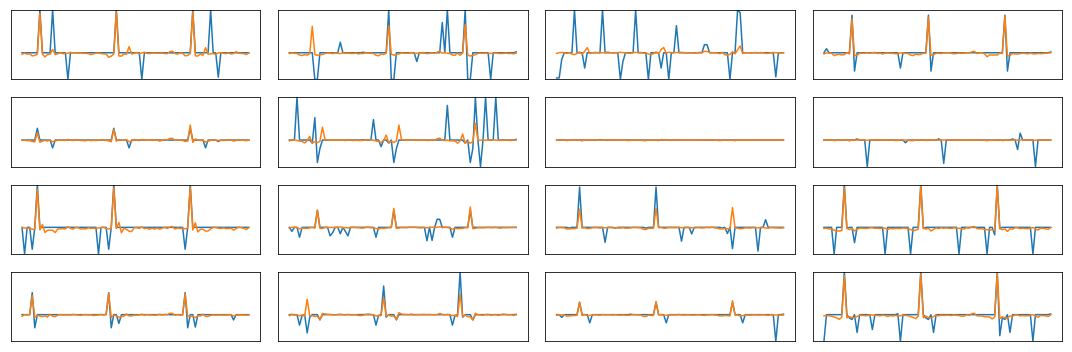

In [89]:
plot_predictions(dense_dense_autoencoder, indexes, transactions)

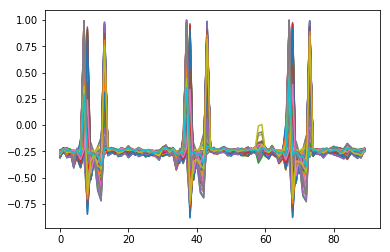

In [98]:
plt.plot(dense_dense_decoder.predict(np.random.uniform(0, 1, (100, 2))).T)
plt.show()

### LSTM-Dense autoencoder

In [45]:
def get_lstm_dense_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr):
    autoencoder = Sequential()
    autoencoder.add(Lambda(lambda x: K.expand_dims(x), input_shape=(timesteps,)))
    autoencoder.add(LSTM(lstm_dim, return_sequences = False))
    autoencoder.add(Dense(latent_dim, activation='relu'))
    autoencoder.add(Dense(timesteps, activation='tanh'))
    
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

lstm_dense_autoencoder = get_lstm_dense_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(lstm_dense_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(lstm_dense_autoencoder, indexes, transactions)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 100, 1)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_29 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_30 (Dense)             (None, 100)               1100      
Total params: 1,510
Trainable params: 1,510
Non-trainable params: 0
_________________________________________________________________
Train on 37721 samples, validate on 16167 samples
Epoch 1/50
 7712/37721 [=====>........................] - ETA: 2:55 - loss: 0.0224

KeyboardInterrupt: 

(1, 100)


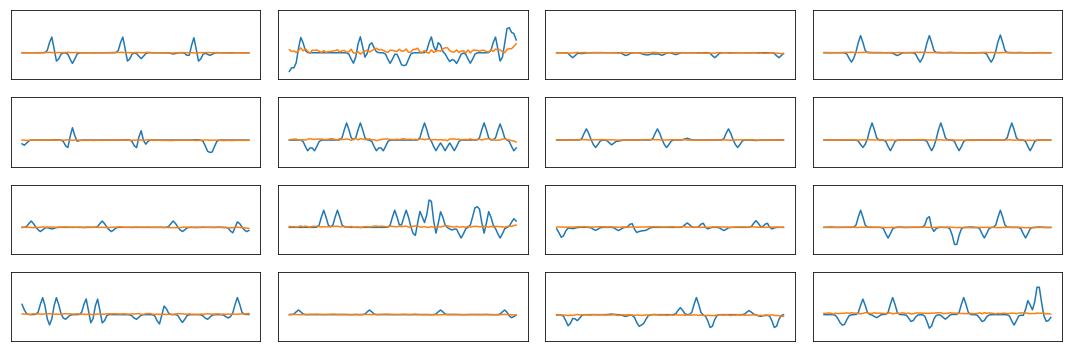

In [46]:
plot_predictions(lstm_dense_autoencoder, indexes, transactions)

### Dense-LSTM autoencoder

In [47]:
def get_dense_lstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr):
    autoencoder = Sequential()
    autoencoder.add(Dense(latent_dim, activation='tanh', input_shape=(timesteps,)))
    autoencoder.add(RepeatVector(timesteps))
    autoencoder.add(LSTM(lstm_dim, return_sequences=True))
    autoencoder.add(TimeDistributed(Dense(1, activation='tanh')))
    autoencoder.add(Lambda(lambda x: K.squeeze(x, -1)))
    
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

dense_lstm_autoencoder = get_dense_lstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(dense_lstm_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(dense_lstm_autoencoder, indexes, transactions)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 10)                1010      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 100, 10)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 8)            608       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 1)            9         
_________________________________________________________________
lambda_4 (Lambda)            (None, 100)               0         
Total params: 1,627
Trainable params: 1,627
Non-trainable params: 0
_________________________________________________________________
Train on 37721 samples, validate on 16167 samples
Epoch 1/50
 4512/37721 [==>...........................] - ETA: 3:41 - loss: 0.0185

KeyboardInterrupt: 

(1, 100)


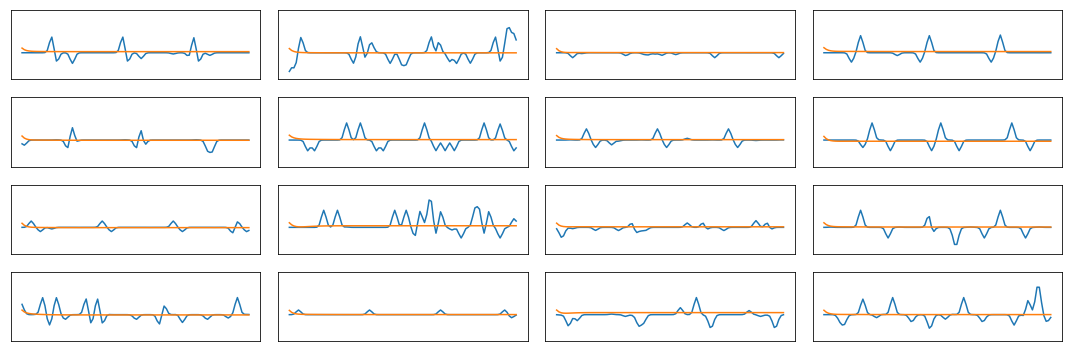

In [48]:
plot_predictions(dense_lstm_autoencoder, indexes, transactions)

### LSTM-LSTM autoencoder

In [49]:
def get_lstm_lstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr):
    autoencoder = Sequential()
    autoencoder.add(Lambda(lambda x: K.expand_dims(x), input_shape=(timesteps,)))
    autoencoder.add(LSTM(lstm_dim, return_sequences = False))
    autoencoder.add(Dense(latent_dim, activation='tanh'))
    autoencoder.add(RepeatVector(timesteps))
    autoencoder.add(LSTM(lstm_dim, return_sequences=True))
    autoencoder.add(TimeDistributed(Dense(1, activation='tanh')))
    autoencoder.add(Lambda(lambda x: K.squeeze(x, -1)))
    
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

lstm_lstm_autoencoder = get_lstm_lstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(lstm_lstm_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(lstm_lstm_autoencoder, indexes, transactions)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 100, 1)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_33 (Dense)             (None, 10)                90        
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 100, 10)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 8)            608       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 100, 1)            9         
_________________________________________________________________
lambda_6 (Lambda)            (None, 100)               0         
Total para

KeyboardInterrupt: 

### BLSTM-BLSTM autoencoder

In [50]:
def get_blstm_blstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr=0.001):
    model_inputs = Input((timesteps,))
    encoder = Lambda(lambda x: K.expand_dims(x))(model_inputs)

    encoder = Bidirectional(LSTM(lstm_dim, return_sequences = False))(encoder)
    encoder = Dense(latent_dim, activation='tanh')(encoder)
    encoder = RepeatVector(timesteps)(encoder)
    
    decoder = Bidirectional(LSTM(lstm_dim, return_sequences=True))(encoder)
    decoder = TimeDistributed(Dense(1, activation='tanh'))(decoder)
    decoder = Lambda(lambda x: K.squeeze(x, -1))(decoder)
    
    autoencoder = Model(model_inputs, decoder)

    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

blstm_blstm_autoencoder = get_blstm_blstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(blstm_blstm_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(blstm_blstm_autoencoder, indexes, transactions)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 100, 1)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                640       
_________________________________________________________________
dense_35 (Dense)             (None, 10)                170       
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 100, 10)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 16)           1216      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 100, 1)            17        
__________

KeyboardInterrupt: 

### BLSTM-BLSTM autoencoder (with steps)

In [ ]:
def get_blstm_blstm_steps_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr=0.001):
    model_inputs = Input((timesteps,))
    encoder = Lambda(lambda x: K.expand_dims(x))(model_inputs)

    model_inputs_2 = Input((timesteps,))
    steps = Lambda(lambda x: K.expand_dims(x))(model_inputs_2)

    encoder = Bidirectional(LSTM(lstm_dim, return_sequences = False))(encoder)
    encoder = Dense(latent_dim, activation='tanh')(encoder)
    encoder = RepeatVector(timesteps)(encoder)
    encoder = concatenate([encoder, steps])
    
    decoder = Bidirectional(LSTM(lstm_dim, return_sequences=True))(encoder)
    decoder = TimeDistributed(Dense(1, activation='tanh'))(decoder)
    decoder = Lambda(lambda x: K.squeeze(x, -1))(decoder)
    
    autoencoder = Model([model_inputs, model_inputs_2], decoder)

    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

steps = np.arange(0, 1, 1/timesteps)
steps = np.tile(steps,(transactions.shape[0],1))

blstm_blstm_steps_autoencoder = get_blstm_blstm_steps_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(blstm_blstm_steps_autoencoder, [transactions, steps], transactions)
plot_history(history)
plot_predictions(blstm_blstm_steps_autoencoder, indexes, transactions, add_timesteps=True)

### Conv Conv autoencoder

In [49]:
def get_conv_conv_autoencoder(timesteps, loss, lr):
    autoencoder_inputs = Input((timesteps, ))
    autoencoded = autoencoder_inputs

    autoencoded = Lambda(lambda x: K.expand_dims(x))(autoencoded)
    while autoencoded.shape[1] > 1:
        autoencoded = Conv1D(32, 3, activation='relu', padding='same')(autoencoded)
        autoencoded = MaxPooling1D(2, padding='same')(autoencoded)
    autoencoded = Flatten()(autoencoded)
    autoencoded = Dense(latent_dim, activation='relu')(autoencoded)

    autoencoded = Lambda(lambda x: K.expand_dims(x))(autoencoded)
    while autoencoded.shape[1] < timesteps:
        autoencoded = Conv1D(32, 3, activation='relu', padding='same')(autoencoded)
        autoencoded = UpSampling1D(2)(autoencoded)
    autoencoded = Conv1D(1, 3, activation='relu', padding='same')(autoencoded)
    autoencoded = Lambda(lambda x: K.squeeze(x, -1))(autoencoded)
    autoencoded = Dense(timesteps, activation='tanh')(autoencoded)

    autoencoder = Model(autoencoder_inputs, autoencoded)
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

conv_conv_autoencoder = get_conv_conv_autoencoder(timesteps, loss, lr)
history = train_autoencoder(conv_conv_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(conv_conv_autoencoder, indexes, transactions)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 90)                0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 90, 1)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 90, 32)            128       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 45, 32)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 45, 32)            3104      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 23, 32)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 23, 32)            3104      
__________

KeyboardInterrupt: 

(1, 90)


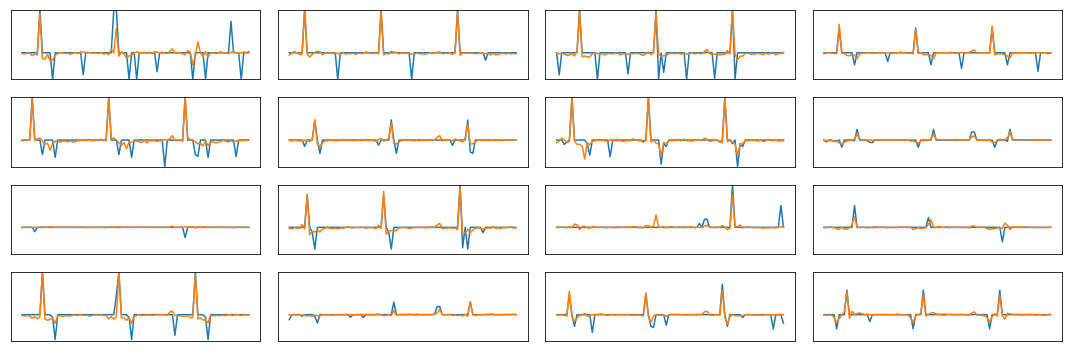

In [50]:
plot_predictions(conv_conv_autoencoder, indexes, transactions)